# DDM for All Control Data

Parse all control data to a single CSV, then check if subject data can fit a hierarchical drift decision model for different stimuli types

Experimental stimuli are as follows:  
- Condition 1: Same stimuli (see cat / hear cat) -- `SS`  
- Condition 2: Phonologically congruent (see cat / hear hat) -- `CP`  
- Condition 3: Semantically congruent (see cat / hear dog) -- `CS`  
- Condition 4: Unrelated stimuli (see house / hear cat)  -- `US`  

### Parse all subject data to single csv

Generate a single csv for all data, using `subject_idx` as a unique patient identifier. 
Also give conditions (`stim`) a 2-character descriptive instead of a number.

CSV fields are as follows:  
- `subj_idx`: Unique subject identifier  
- `rt`: Reaction time  
- `stim`: Stimulus (SS/CP/CS/US)  
- `response`: Response to stimulus (True(1)/False(0))  

In [21]:
def parse_condition(stim_num):
    if stim_num == '1':
        return 'SS'
    if stim_num == '2':
        return 'CP'
    if stim_num == '3':
        return 'CS'
    if stim_num == '4':
        return 'US'

In [31]:
import csv
import glob 


csv_dir = '../data/pilot_subjects/'
subjects = []

for csv_file in glob.glob(csv_dir + 'data*.csv'):
    subject = []
    subj_idx = csv_file[-9:-4]  # Use id from filename
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for trial in reader:
            trial['subj_idx'] = subj_idx
            trial['stim'] = parse_condition(trial['stim'])
            subject.append(trial)
    subjects.append(subject)
    
keys = subject[0].keys()

with open('../data/all_subjects.csv', 'w') as out:
        writer = csv.DictWriter(out, keys)
        writer.writeheader()
        for subj in subjects:
            writer.writerows(subj)

## First stab at hddm model fit

In [43]:
import hddm

data = hddm.load_csv('../data/all_subjects_clean.csv')

model = hddm.HDDM(data, depends_on={'v': 'stim'})
model.find_starting_values()
model.sample(6000, burn=20)

/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 6001 of 6000 complete in 252.9 sec

/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [44]:
model.print_stats()

/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


                       mean        std       2.5q        25q        50q        75q      97.5q       mc err
a                   2.39487   0.149777    2.11184    2.29264    2.39091    2.49519    2.70116    0.0031287
a_std              0.561054   0.127484   0.367758   0.471567   0.544664    0.62876   0.869204    0.0027293
a_subj.17991        3.52299   0.244416    3.06791    3.35454    3.50959    3.68482    4.02235   0.00776651
a_subj.18288         2.3844    0.16777    2.08287    2.26796    2.37858    2.49065    2.74353   0.00484068
a_subj.18325        2.77195   0.257164    2.32923    2.59257    2.75384    2.93286    3.32913    0.0103913
a_subj.18333        2.28428   0.159303     1.9985    2.17061    2.27763    2.38864    2.61322   0.00440774
a_subj.18334        2.40914   0.232765     2.0168    2.24287    2.38893    2.55274    2.92009    0.0103848
a_subj.18350        1.63838    0.12733    1.41666    1.54945    1.62948    1.71725    1.91446   0.00396113
a_subj.18547        1.75478   0.11530

#### Plot posteriors

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std


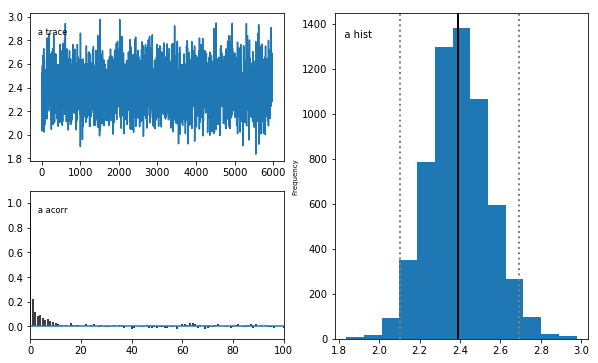

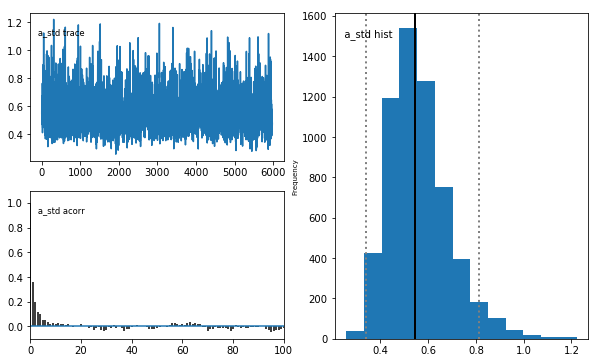

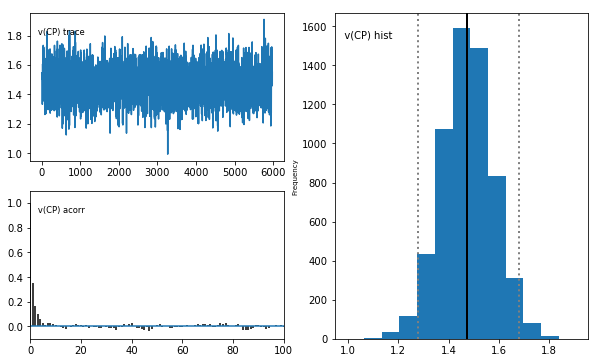

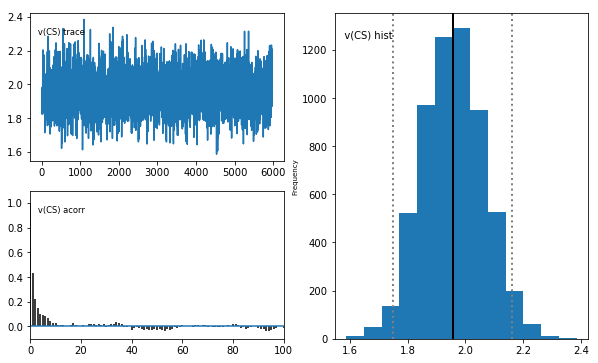

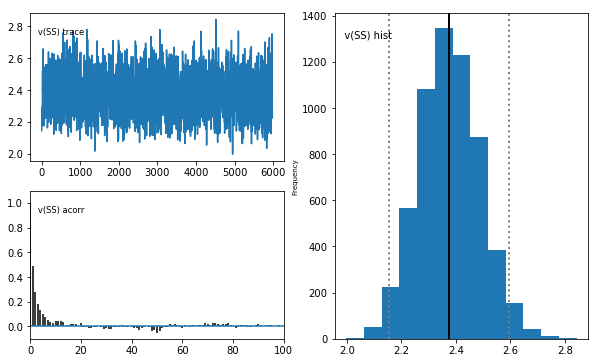

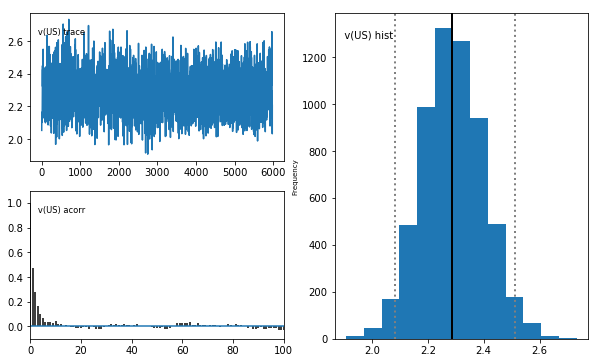

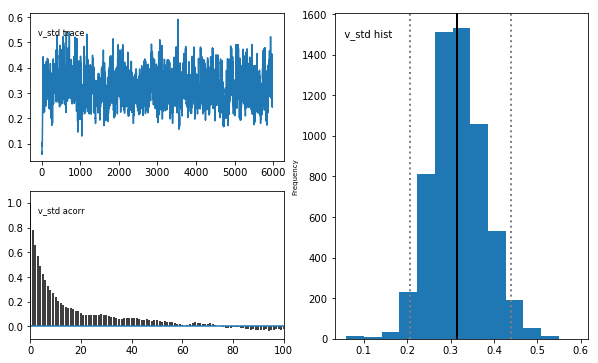

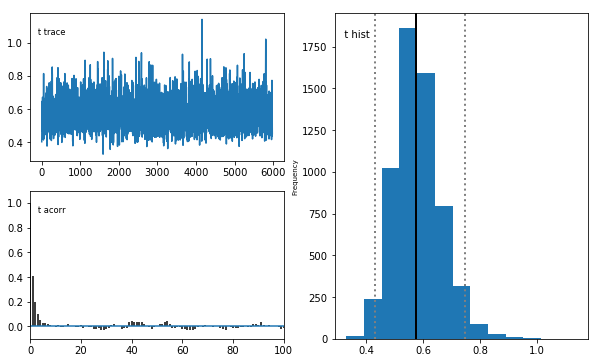

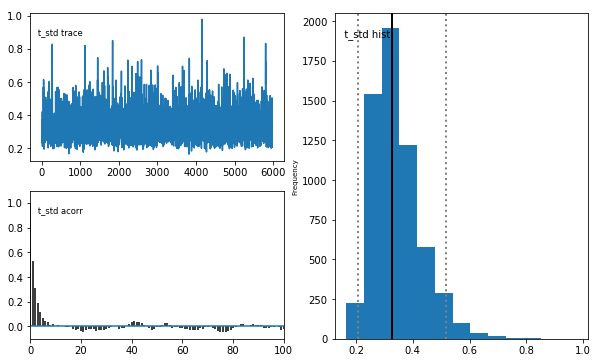

In [45]:
%matplotlib inline
model.plot_posteriors()

#### Plot posterior of drift rate for group means

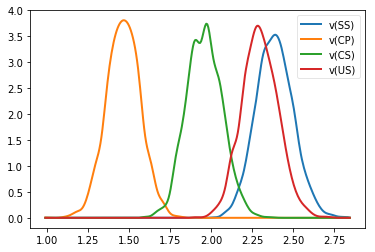

In [46]:
v_SS, v_CP, v_CS, v_US = model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

Calculate the proportion of the posteriors in which the drift rate for one condition is greater than the other

In [54]:
print('P(SS > US) = ' + str((v_SS.trace() > v_US.trace()).mean()))
print('P(CP > SS) = ' + str((v_CP.trace() > v_SS.trace()).mean()))
print('P(CS > SS) = ' + str((v_CS.trace() > v_SS.trace()).mean()))
print('P(CP > CS) = ' + str((v_CP.trace() > v_CS.trace()).mean()))

P(SS > US) = 0.728428093645
P(CP > SS) = 0.0
P(CS > SS) = 0.00150501672241
P(CP > CS) = 0.000167224080268


Therefore:  
- The drift rate for **CP** is significantly lower than all other conditions  
- The drift rate for **CS** is significantly lower than **SS** and **US**, but significantly higher than **CP**  
- The drift rates for **SS** and **US** are not significantly different  

#### Check for model convergence 

In [48]:
models = []
for i in range(5):
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models)

/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 6000 of 6000 complete in 250.5 sec

/Users/constantinose/anaconda/envs/lang-dec/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


 [-----------------100%-----------------] 6000 of 6000 complete in 262.8 sec

{'a': 1.0000939876591226,
 'a_std': 0.99996962476751206,
 'a_subj.17991': 1.000982946256135,
 'a_subj.18288': 1.0003417787402629,
 'a_subj.18325': 1.0007354129836661,
 'a_subj.18333': 1.0009568723610807,
 'a_subj.18334': 1.0011054914612583,
 'a_subj.18350': 1.0004064640520569,
 'a_subj.18547': 0.99993520136449598,
 'a_subj.18619': 1.0024855152608905,
 'a_subj.18864': 1.0010252816972853,
 'a_subj.18919': 1.0005636345976523,
 'a_subj.18977': 1.00033218051762,
 'a_subj.18978': 1.0010533196442186,
 'a_subj.18979': 1.0008918377075464,
 'a_subj.18988': 1.001188934315556,
 'a_subj.19686': 1.0005242606704636,
 'a_subj.19687': 0.99994866837577912,
 't': 1.0004833696484634,
 't_std': 1.0005698875959819,
 't_subj.17991': 1.0005935832511212,
 't_subj.18288': 1.0001767506801551,
 't_subj.18325': 1.0008609439770375,
 't_subj.18333': 1.0012522239232304,
 't_subj.18334': 1.0009125737504687,
 't_subj.18350': 1.0005610294409997,
 't_subj.18547': 1.0001519900257134,
 't_subj.18619': 1.0021943321192976,
 

Models converge!